In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot2, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT
from Welch_func import Welch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (2000, 4000)
Clean_data.shape: (2000, 4000)


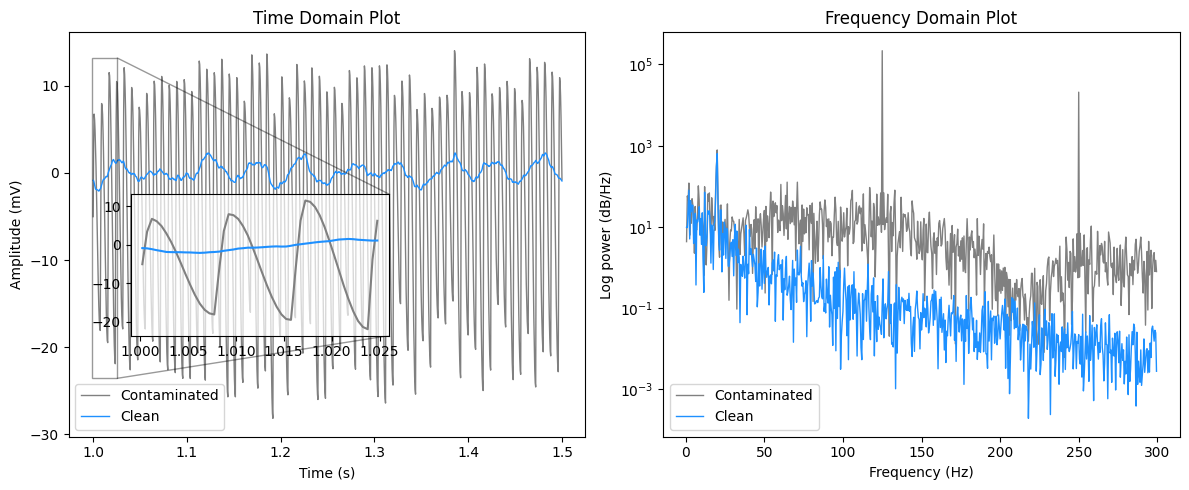

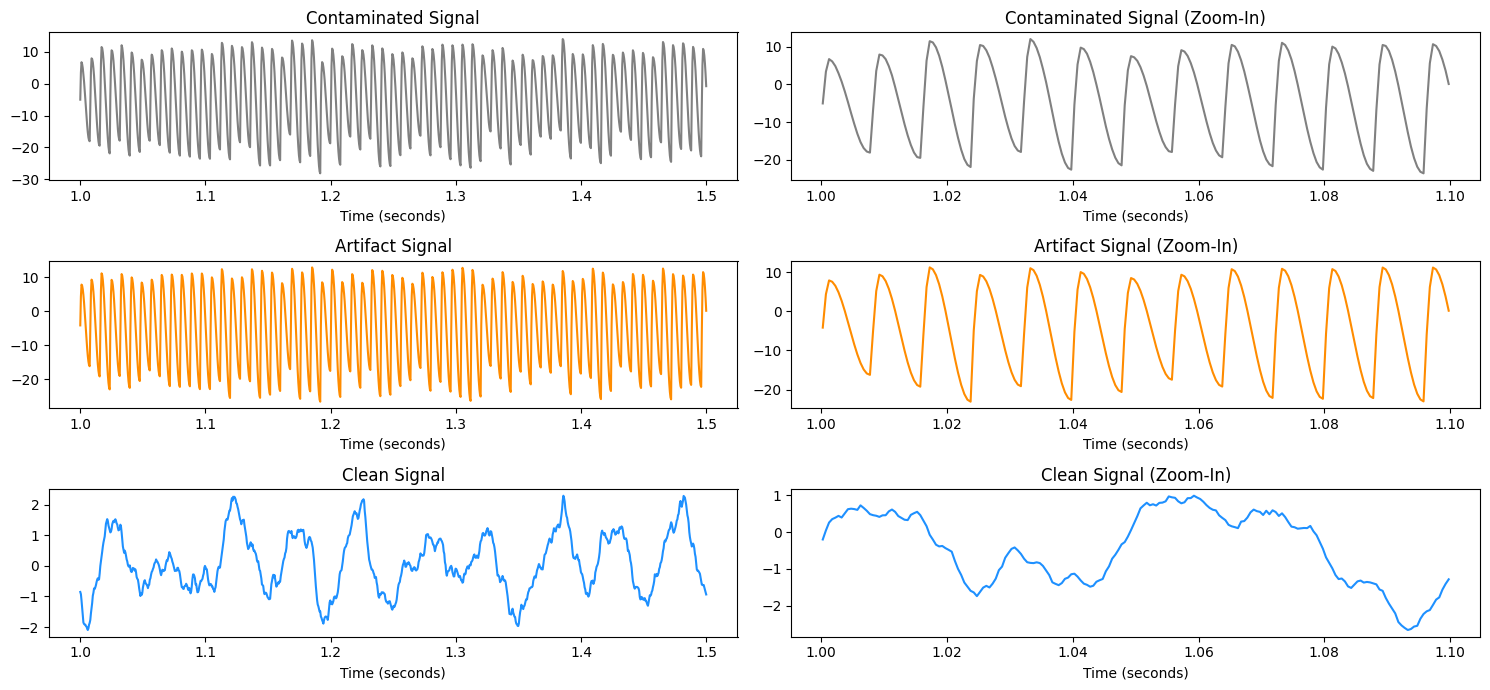

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (2000, 4000)
y: (2000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (1600, 4000), y_train shape: (1600, 4000)
X_test shape: (400, 4000), y_test shape: (400, 4000)
unsqueezed X_train shape: (1600, 1, 4000), y_train shape: (1600, 4000)
unsqueezed X_test shape: (400, 1, 4000), y_test shape: (400, 4000)


In [5]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        x = x.squeeze(1) # x : B x T
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [6]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.0024281612131744623
Epoch 10/200, Loss: 0.0012487893691286445
Epoch 15/200, Loss: 0.0008546006865799427
Epoch 20/200, Loss: 0.0008589485660195351
Epoch 25/200, Loss: 0.0008336985483765602
Epoch 30/200, Loss: 0.0006517564179375768
Epoch 35/200, Loss: 0.0006681828526780009
Epoch 40/200, Loss: 0.0007645050063729286
Epoch 45/200, Loss: 0.0005842452519573271
Epoch 50/200, Loss: 0.0006207424448803067
Epoch 55/200, Loss: 0.0005877502262592316
Epoch 60/200, Loss: 0.0005759289488196373
Epoch 65/200, Loss: 0.0005605776677839458
Epoch 70/200, Loss: 0.0005815905751660466
Epoch 75/200, Loss: 0.000521377136465162
Epoch 80/200, Loss: 0.0006261760136112571
Epoch 85/200, Loss: 0.000599163759034127
Epoch 90/200, Loss: 0.0006315243081189692
Epoch 95/200, Loss: 0.0005728952237404883
Epoch 100/200, Loss: 0.0004916919860988855
Epoch 105/200, Loss: 0.0005725589580833912
Epoch 110/200, Loss: 0.000502348062582314
Epoch 115/200, Loss: 0.0005317789036780596
Epoch 120/200, Loss: 0.00047802311

In [7]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 0.00044340285239741206


In [8]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# result_data = [Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled]
# save_path = '../../../result/output_data/'
# np.save(save_path + "model_output" + ".npy", result_data)

In [ ]:
evaluation_fpath = '../../../data/evaluation_data/'
Contaminated_evaluation = np.load(evaluation_fpath + 'contaminated_by_realistic.npy')
Clean_evaluation = np.load(evaluation_fpath + 'clean_by_realistic.npy')

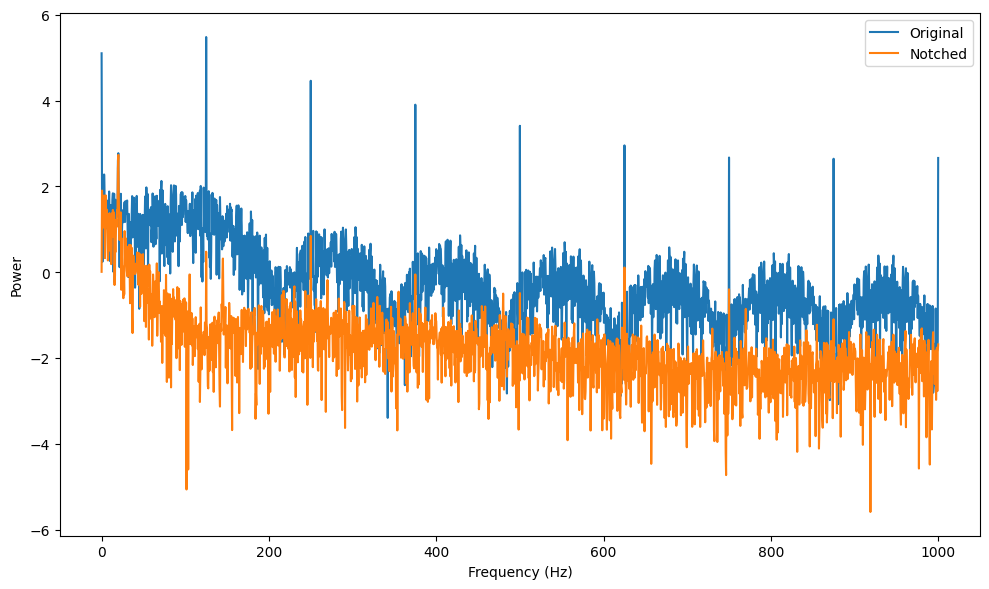

In [9]:
fs =2000
freqs,_,_,psd_Contaminated = FFT(Contaminated_inv_scaled, fs, single_sided=True)
_,_,_,psd_SACed = FFT(SACed_inv_scaled, fs, single_sided=True)
_,_,_,psd_Clean = FFT(Clean_inv_scaled, fs, single_sided=True)

# 결과 출력
plt.figure(figsize=(10, 6))


plt.plot(freqs, np.log10(psd_Contaminated[0]))
plt.plot(freqs, np.log10(psd_SACed[0]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend(['Original', 'Notched'])

plt.tight_layout()
plt.show()

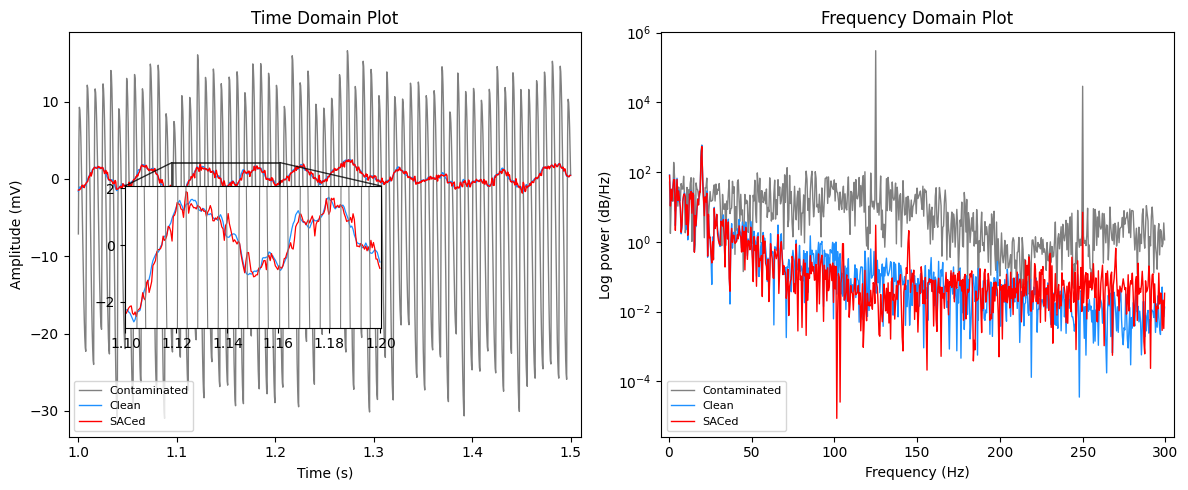

< MSE >
Time Domain MSE: 0.05682237758329146 ± 0.006205735315644589
Frequency Domain MSE: 2.909747590508524 ± 1.1275293813709502


In [10]:
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

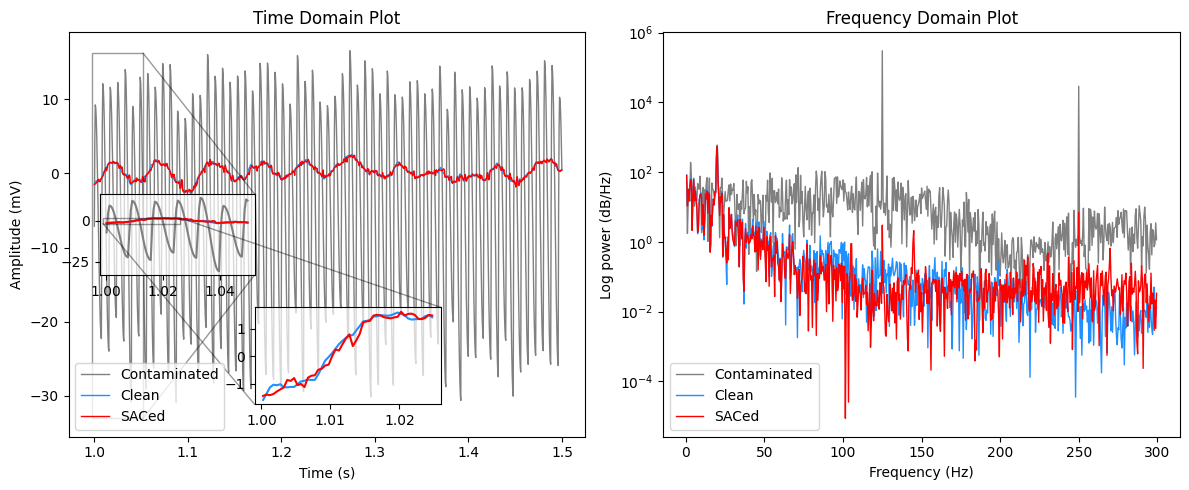

< MSE >
Time Domain MSE: 0.05682237758329146 ± 0.006205735315644589
Frequency Domain MSE: 2.909747590508524 ± 1.1275293813709502


In [11]:
# 결과 Plot
Result_Plot2(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

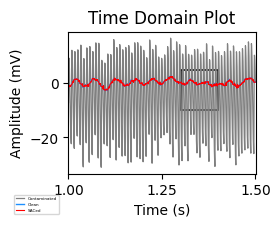

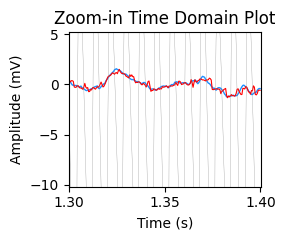

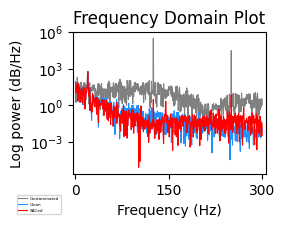

< MSE >
Time Domain MSE: 0.05682237758329146 ± 0.006205735315644589
Frequency Domain MSE: 2.909747590508524 ± 1.1275293813709502


In [12]:
Result_Plot_paper(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음